In [ ]:
pip install librosa numpy pandas scikit-learn tensorflow matplotlib

Defining Categories of Emotions


In [ ]:
# Original 8 emotion labels
emotion_dict = {
    "01": "neutral",
    "02": "neutral",  # Mapping 'calm' as 'neutral'
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "sad",  # Mapping 'fearful' as 'sad'
    "07": "angry",  # Mapping 'disgust' as 'angry'
    "08": "happy"   # Mapping 'surprised' as 'happy'
}

# Define the final emotion categories
final_emotions = ["angry", "sad", "neutral", "happy"]


# **Dataset Uploading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01'

# **Using CNN Model**


Feature Extraction using MFCC


In [ ]:
import os
import librosa
import numpy as np

def extract_features(dataset_path):
    features = []
    labels = []

    for file in os.listdir(dataset_path):
        if file.endswith(".wav"):
            file_path = os.path.join(dataset_path, file)

            # Load audio file
            y, sr = librosa.load(file_path, sr=None)

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfccs = np.mean(mfccs, axis=1)  # Take mean across time

            features.append(mfccs)

            # Extract emotion from filename and map to 4-class label
            filename_parts = file.split("-")  # Split filename
            emotion_code = filename_parts[2]  # 3rd element is emotion code
            emotion_label = emotion_dict[emotion_code]  # Convert to 4 emotions

            labels.append(emotion_label)

    return np.array(features), np.array(labels)

# Extract features and labels
X, y = extract_features(dataset_path)

print("Feature Shape:", X.shape)  # Expected: (num_samples, 40)
print("Labels Shape:", y.shape)    # Expected: (num_samples,)

Feature Shape: (1443, 40)
Labels Shape: (1443,)


Encode Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts "happy" → 0, "sad" → 1, etc.

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y_encoded, num_classes=4)


Split Dataset

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

print("Updated Labels:", label_encoder.classes_)  # Should print ['angry' 'happy' 'neutral' 'sad']
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Updated Labels: ['angry' 'happy' 'neutral' 'sad']
Training Data Shape: (1154, 40)
Testing Data Shape: (289, 40)


Normalize MFCC Features

In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Reshape Data for CNN

In [ ]:
# Reshape for CNN (Adding a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("CNN Input Shape:", X_train_cnn.shape)


CNN Input Shape: (1154, 40, 1)


Perform Data Augmentation

In [ ]:
import random

def augment_data(X, y):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        augmented_X.append(X[i])
        augmented_y.append(y[i])

        # Add small noise for augmentation
        if random.random() > 0.5:
            noise = np.random.normal(0, 0.01, X[i].shape)
            augmented_X.append(X[i] + noise)
            augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)

# Apply augmentation to training data
X_train, y_train = augment_data(X_train, y_train)

print("Augmented Training Set Shape:", X_train.shape)


Augmented Training Set Shape: (1719, 40)


In [ ]:
print(y_train.shape, y_test.shape)


(1719, 4) (289, 4)


 Build and Train the CNN Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming X_train and X_test have shape (num_samples, 40)
# We need to reshape for CNN: (samples, features, 1)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Build CNN model
cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # num_classes defined earlier
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train the CNN model
history_cnn = cnn_model.fit(X_train_cnn, y_train,
                            epochs=100,
                            batch_size=64,
                            validation_data=(X_test_cnn, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 38, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,204 (1.23 MB)

 Trainable params: 322,308 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.3850 - loss: 1.9130 - val_accuracy: 0.3495 - val_loss: 1.3363
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6402 - loss: 0.9263 - val_accuracy: 0.3633 - val_loss: 1.3106
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7886 - loss: 0.5576 - val_accuracy: 0.4118 - val_loss: 1.2822
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8682 - loss: 0.3578 - val_accuracy: 0.4879 - val_loss: 1.2296
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9188 - loss: 0.2460 - val_accuracy: 0.4671 - val_loss: 1.1826
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9582 - loss: 0.1551 - val_accuracy: 0.3702 - val_loss: 1.3063
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9663 - loss: 0.1200 - val_accuracy: 0.4325 - val_loss: 1.1687
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9768 - loss: 0.0863 - val_accuracy: 0.

Evaluate the CNN Model

In [45]:
# Evaluate on test set
test_loss, test_acc1 = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy (CNN): {test_acc1:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8117 - loss: 0.8450
Test Accuracy (CNN): 0.80


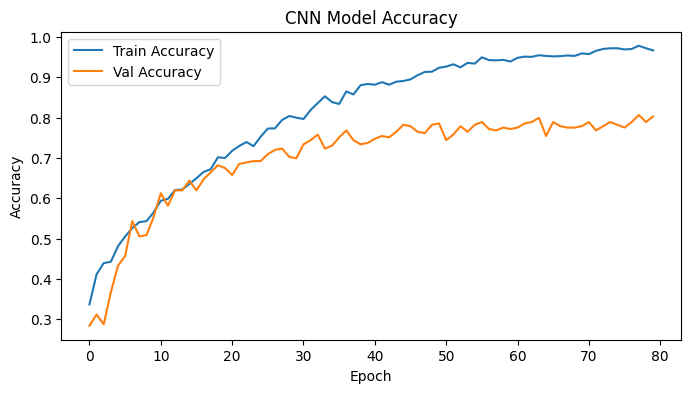

In [46]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CNN Model Accuracy")
plt.show()

# Testing the model with an Audio File

In [ ]:
import librosa
import numpy as np

def extract_mfcc(file_path, n_mfcc=40):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Take the mean across time frames to get a fixed-size input
    mfcc_mean = np.mean(mfcc, axis=1)

    return mfcc_mean

# Example: Extract MFCC features from an audio file
sample_audio = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-02.wav"  # Audio File with Neutral Emotion
mfcc_features = extract_mfcc(sample_audio)

print("MFCC Shape:", mfcc_features.shape)


MFCC Shape: (40,)


In [ ]:
# Reshape for CNN input format
mfcc_features = mfcc_features.reshape(1, 40, 1)  # (1 sample, 40 features, 1 channel)


Making the Prediction

In [ ]:
# Make prediction
y_pred = cnn_model.predict(mfcc_features)

# Get the predicted label (index of highest probability)
predicted_label = np.argmax(y_pred)

# Map label index to emotion class
emotion_classes = label_encoder.classes_  # ['angry', 'happy', 'neutral', 'sad']
predicted_emotion = emotion_classes[predicted_label]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Predicted Emotion: neutral


# Hyperparameter Tunning

First

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts "happy" → 0, "sad" → 1, etc.

# Convert labels to one-hot encoding (only 4 classes)
y_one_hot = to_categorical(y_encoded, num_classes=4)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

print("Updated Labels:", label_encoder.classes_)  # Should print ['angry' 'happy' 'neutral' 'sad']
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

# Data Augmentation
import random

def augment_data(X, y):
    augmented_X = []
    augmented_y = []

    for i in range(len(X)):
        augmented_X.append(X[i])
        augmented_y.append(y[i])

        # Add small noise for augmentation
        if random.random() > 0.5:
            noise = np.random.normal(0, 0.01, X[i].shape)
            augmented_X.append(X[i] + noise)
            augmented_y.append(y[i])

    return np.array(augmented_X), np.array(augmented_y)

# Apply augmentation to training data
X_train, y_train = augment_data(X_train, y_train)

print("Augmented Training Set Shape:", X_train.shape)

# Reshape for CNN (Adding a channel dimension)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("CNN Input Shape:", X_train_cnn.shape)

import tensorflow as tf
from tensorflow.keras import layers, models

# Build CNN model
cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # Matching 4 emotion classes
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train the CNN model
history_cnn = cnn_model.fit(X_train_cnn, y_train,
                            epochs=100,
                            batch_size=64,
                            validation_data=(X_test_cnn, y_test))


Updated Labels: ['angry' 'happy' 'neutral' 'sad']
Training Data Shape: (1154, 40)
Testing Data Shape: (289, 40)
Augmented Training Set Shape: (1756, 40)
CNN Input Shape: (1756, 40, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 38, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,204 (1.23 MB)

 Trainable params: 322,308 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.3910 - loss: 1.8553 - val_accuracy: 0.2526 - val_loss: 1.6613
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6047 - loss: 0.9941 - val_accuracy: 0.2734 - val_loss: 1.6685
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7158 - loss: 0.7199 - val_accuracy: 0.2941 - val_loss: 1.6570
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7914 - loss: 0.5788 - val_accuracy: 0.3287 - val_loss: 1.7169
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8425 - loss: 0.4525 - val_accuracy: 0.4083 - val_loss: 1.3735
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8798 - loss: 0.3554 - val_accuracy: 0.5156 - val_loss: 1.1241
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8806 - loss: 0.3112 - val_accuracy: 0.5363 - val_loss: 1.1987
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9210 - loss: 0.2272 - val_accuracy: 0.

In [48]:
# Evaluate on test set
test_loss, test_acc2 = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy (CNN): {test_acc2:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8202 - loss: 1.3041 
Test Accuracy (CNN): 0.82


Second

In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming X_train and X_test have shape (num_samples, 40)
# We need to reshape for CNN: (samples, features, 1)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Build CNN model
cnn_model = models.Sequential([
    layers.Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train the CNN model
history_cnn = cnn_model.fit(X_train_cnn, y_train,
                            epochs=100,
                            batch_size=20,
                            validation_data=(X_test_cnn, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 38, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 38, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 17, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 546,180 (2.08 MB)

 Trainable params: 545,156 (2.08 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.3979 - loss: 1.8639 - val_accuracy: 0.2803 - val_loss: 1.8171
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5909 - loss: 0.9675 - val_accuracy: 0.3841 - val_loss: 1.3468
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6783 - loss: 0.7771 - val_accuracy: 0.4983 - val_loss: 1.1792
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7283 - loss: 0.6515 - val_accuracy: 0.6263 - val_loss: 0.9344
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8126 - loss: 0.5247 - val_accuracy: 0.6644 - val_loss: 0.9285
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8446 - loss: 0.4262 - val_accuracy: 0.6471 - val_loss: 0.9407
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8858 - loss: 0.3031 - val_accuracy: 0.6851 - val_loss: 0.8772
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9074 - loss: 0.2705 - val_accuracy: 0.

In [51]:
# Evaluate on test set
test_loss, test_acc3 = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy (CNN): {test_acc3:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7775 - loss: 1.6604
Test Accuracy (CNN): 0.75


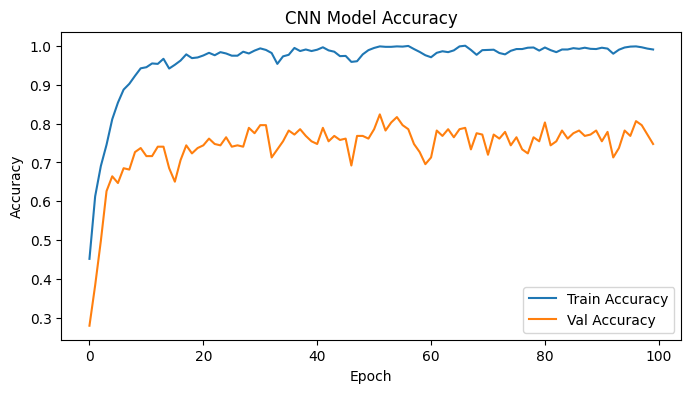

In [52]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CNN Model Accuracy")
plt.show()

Third

In [53]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam

# Build an improved CNN model
cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1),
                  kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),  # Reduced Dropout

    layers.Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.1),  # Slightly lower dropout

    layers.Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.3),  # Lower dropout in Dense layer
    layers.Dense(4, activation='softmax')  # 4 emotion classes
])

# Change optimizer to Adam (better adaptation)
cnn_model.compile(optimizer=Adam(learning_rate=0.0005),  # Lower learning rate for stability
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

# Train the CNN model
history_cnn = cnn_model.fit(X_train_cnn, y_train,
                            epochs=80,  # Reduce total epochs for better monitoring
                            batch_size=64,  # Increased batch size for better updates
                            validation_data=(X_test_cnn, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 38, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_20 (Conv1D)                   │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,260 (876.02 KB)

 Trainable params: 223,364 (872.52 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.3057 - loss: 2.1819 - val_accuracy: 0.2561 - val_loss: 1.6168
Epoch 2/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3933 - loss: 1.6054 - val_accuracy: 0.2595 - val_loss: 1.6152
Epoch 3/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3999 - loss: 1.4908 - val_accuracy: 0.2595 - val_loss: 1.6132
Epoch 4/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4441 - loss: 1.4003 - val_accuracy: 0.2803 - val_loss: 1.5804
Epoch 5/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.4942 - loss: 1.3709 - val_accuracy: 0.3183 - val_loss: 1.5442
Epoch 6/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4964 - loss: 1.3313 - val_accuracy: 0.3702 - val_loss: 1.4861
Epoch 7/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5311 - loss: 1.2915 - val_accuracy: 0.4083 - val_loss: 1.4366
Epoch 8/80
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5253 - loss: 1.2873 - val_accuracy: 0.4394 - v

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7957 - loss: 0.8707
Test Accuracy (CNN): 0.79


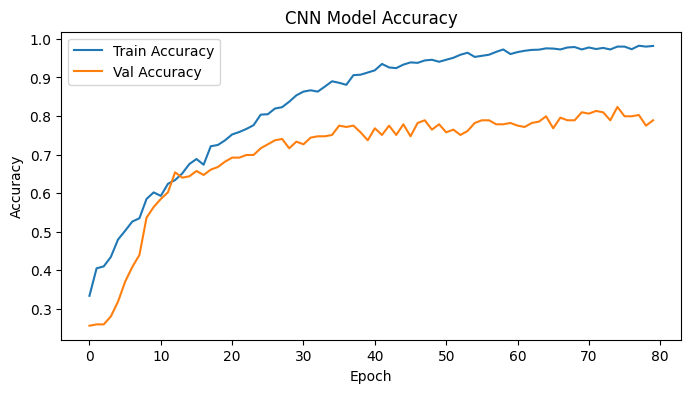

In [55]:
import matplotlib.pyplot as plt
# Evaluate on test set
test_loss, test_acc4 = cnn_model.evaluate(X_test_cnn, y_test)
print(f"Test Accuracy (CNN): {test_acc4:.2f}")

# Plot Accuracy
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CNN Model Accuracy")
plt.show()


In [ ]:
import librosa
import numpy as np

def extract_mfcc(file_path, n_mfcc=40):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Take the mean across time frames to get a fixed-size input
    mfcc_mean = np.mean(mfcc, axis=1)

    return mfcc_mean

# Example: Extract MFCC features from an audio file
sample_audio = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-03-01-01-01-07.wav"  # Audio file with happy emotion
mfcc_features = extract_mfcc(sample_audio)

print("MFCC Shape:", mfcc_features.shape)  # Should be (40,)


MFCC Shape: (40,)


In [ ]:
# Reshape for CNN input format
mfcc_features = mfcc_features.reshape(1, 40, 1)  # (1 sample, 40 features, 1 channel)


In [ ]:
# Make prediction
y_pred = cnn_model.predict(mfcc_features)

# Get the predicted label (index of highest probability)
predicted_label = np.argmax(y_pred)

# Map label index to emotion class
emotion_classes = label_encoder.classes_  # ['angry', 'happy', 'neutral', 'sad']
predicted_emotion = emotion_classes[predicted_label]

print(f"Predicted Emotion: {predicted_emotion}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Predicted Emotion: happy


## Using SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize SVM model
svm_model = SVC(kernel='rbf', C=10, gamma='scale')  # Radial Basis Function (RBF) kernel

# Train the model
svm_model.fit(X_train, y_train.argmax(axis=1))  # Convert one-hot labels to single-label encoding

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate SVM model
svm_acc = accuracy_score(y_test.argmax(axis=1), y_pred_svm)
print(f"SVM Accuracy: {svm_acc:.2f}")


SVM Accuracy: 0.48


# **Using Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train.argmax(axis=1))

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_acc = accuracy_score(y_test.argmax(axis=1), y_pred_rf)
print(f"Random Forest Accuracy: {rf_acc:.2f}")


Random Forest Accuracy: 0.74


Hypterparameter Tunning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train.argmax(axis=1))

print("Best Random Forest Parameters:", grid_search.best_params_)
print("Best Random Forest Accuracy:", grid_search.best_score_)


Best Random Forest Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest Accuracy: 0.7364884560601543


# **Using XGB Classifier**

In [38]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train.argmax(axis=1))

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_acc = accuracy_score(y_test.argmax(axis=1), y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.2f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:18:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.70


Hypterparameter Tunning

In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train.argmax(axis=1))

print("Best XGBoost Parameters:", grid_search.best_params_)
print("Best XGBoost Accuracy:", grid_search.best_score_)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:30:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best XGBoost Accuracy: 0.7393769253701679


Performance with tuned parameter

In [40]:
from xgboost import XGBClassifier

# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.2, max_depth=5, use_label_encoder=False, eval_metric='mlogloss')

# Train the model
xgb_model.fit(X_train, y_train.argmax(axis=1))

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_acc = accuracy_score(y_test.argmax(axis=1), y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_acc:.2f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:33:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.75


# **Model Performance Comparison**

In [70]:
print("\nModel Performance Comparison:")
print(f"CNN Accuracy: {test_acc2:.2f}")
print(f"SVM Accuracy: {svm_acc:.2f}")
print(f"Random Forest Accuracy: {rf_acc:.2f}")
print(f"XGBoost Accuracy: {xgb_acc:.2f}")



Model Performance Comparison:
CNN Accuracy: 0.82
SVM Accuracy: 0.48
Random Forest Accuracy: 0.74
XGBoost Accuracy: 0.75


#**Saving the Model with best Performance**

In [71]:
import joblib
from tensorflow.keras.models import save_model, load_model

# Store model accuracies in a dictionary
model_performance = {
    "CNN": test_acc2,
    "SVM": svm_acc,
    "Random_Forest": rf_acc,
    "XGBoost": xgb_acc
}

# Identify the best model
best_model_name = max(model_performance, key=model_performance.get)
best_accuracy = model_performance[best_model_name]

print(f"\n Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

# Save the best model
if best_model_name == "CNN":
    save_model(cnn_model, "best_model.h5")  # Save Keras model
elif best_model_name == "MLP":
    save_model(mlp_model, "best_model.h5")
else:  # For SVM, Random Forest, and XGBoost
    joblib.dump(eval(best_model_name.lower() + "_model"), "best_model.pkl")

print(f" Best model saved as {'best_model.h5' if best_model_name in ['CNN', 'MLP'] else 'best_model.pkl'}")



 Best Model: CNN with Accuracy: 0.8166
 Best model saved as best_model.h5


In [80]:
if best_model_name in ["CNN", "MLP"]:
    best_model = load_model("best_model.h5")  # Load Keras model
else:
    best_model = joblib.load("best_model.pkl")  # Load ML model

print(f"\n Loaded best model: {best_model_name}")



 Loaded best model: CNN


# **Testing the model**

In [82]:
emotion_labels = ["Angry", "Sad", "Neutral", "Happy"]

In [84]:
sample_audio = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-05-01-01-01-17.wav"  # Audio File with angy emotion

# Extract MFCC Features
mfcc_features = extract_mfcc(sample_audio)

# Reshape for model input
mfcc_features = np.expand_dims(mfcc_features, axis=0)  # Shape: (1, 40)

# Convert to correct dtype
mfcc_features = mfcc_features.astype(np.float32)

# 🔹 Make Predictions
predictions = best_model.predict(mfcc_features)

# 🔹 Convert prediction to class label
if best_model_name in ["CNN", "MLP"]:
    predicted_label = np.argmax(predictions)  # Get index of highest probability
else:
    predicted_label = int(predictions[0])  # ML models output a direct class

predicted_emotion = emotion_labels[predicted_label]  # Map index to emotion

# 🔹 Print the Predicted Emotion
print(f"\n Predicted Emotion: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

 Predicted Emotion: Angry
